# Low Dimensional Embedding of Malicious Software Images

Computer vision is playing an increasingly important rolein automated malware detection with to the rise of the image-based binary representation. These binary images are fast to generate, require no feature engineering, and are resilient to popular obfuscation methods. 

In this lab, we walk through how to use GPU accelerated dimensionality reduction (PCA) to embed different *types* of malicious software represented as binary images. We obtain these malicious binary images from the [**MalNet**](https://mal-net.org/) database. Specifically, we will look at how to:

- *Download and process the data* (**Part 1:** 5 min),
- *Implement dimensionality reduction using GPU accelerated PCA* (**Part 2:** 5 min)
- *Visualize low dimensional embeddings* (**Part 3:** 2 min)

## Part1. Downloading and processing the data

We download the image data from the MalNet database and store it locally in the folder `notebooks/`.

In [1]:
import os
import shutil
import requests

def download_data(url, target_path):
    """
    Download MalNet-Tiny data to the local device
    :param: url: a string representing the url download location
    :param: target_path: a string representing the local storage location
    """

    response = requests.get(url, stream=True)
  
    # check that the data was successfully retrieved
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())

    # uncompress the downloads
    shutil.unpack_archive(target_path, 'notebooks/')

# download MalNet-Tiny data (~5GB)
download_data(url='http://malnet.cc.gatech.edu/image-data/malnet-images-tiny.tar.gz', target_path='notebooks/malnet-images-tiny.tar.gz')

#!wget http://malnet.cc.gatech.edu/image-data/malnet-images-tiny.tar.gz

Now that the data has been downloaded, lets gather the image file paths and labels. We load each image as a 1D array, allowing us to form a 2D matrix where each row represents an image, and the columns pixel intensities.

In [2]:
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
from collections import defaultdict


def get_info(file_type='train'):
    """
    Get the files and labels for the train, val or test data

    :param files: string representing whether to load the 'train', 'val' or 'test' data
    :return: list of image filepaths, list of labels, list of label names, inverse label dictionary
    """

    # list of image paths
    files = glob('notebooks/malnet-images-tiny/{}/*/*/*.png'.format(file_type))

    # label dictionary mapping malware numbers to names and vice-versa
    image_types = sorted(list(set([file.split('malnet-images-tiny/{}/'.format(file_type))[1].split('/')[0] for file in files])))
    label_dict = {t: idx for idx, t in enumerate(image_types)}
    label_name_map = {v: k for k, v in label_dict.items()}

    # list of labels 
    labels = [label_dict[file.split('malnet-images-tiny/{}/'.format(file_type))[1].split('/')[0]] for file in files]
    # list of label names
    labels_name = [file.split('malnet-images-tiny/{}/'.format(file_type))[1].split('/')[0] for file in files]

    return files, labels, labels_name, label_name_map


def filter_by_type(files, labels, labels_name, types_to_keep):
    """
    Reduce number of malware classes.

    :param files: list of image paths
    :param labels: list of numeric labels
    :param labels_name: list of label names 
    :param types_to_keep: list of malware classes to keep
    """
    files_kept, labels_kept, labels_names_kept = [], [], []

    # iterate through each image label
    for idx, name in enumerate(labels_name):

      # check if the label is the "types to keep"
      if name in types_to_keep:
          labels_names_kept.append(name)

          files_kept.append(files[idx])
          labels_kept.append(labels[idx])

    return files_kept, labels_kept, labels_names_kept

def load_image(file):
    """
    Load the image from the file and convert it into a 1D numpy array
    :return: 1D numpy array representing an image
    """

    # load image; convert to grayscale; downsample to 64x64 pixels
    img = Image.open(file).convert('L').resize(size=(64, 64), resample=Image.ANTIALIAS)

    # convert image to 2D numpy array and then flatten to 1D
    arr = np.asarray(np.asarray(img).flatten() / 255.0, dtype=np.float32)

    return arr

files, labels, labels_name, label_name_map = get_info(file_type='train',)
files, labels, labels_name = filter_by_type(files, labels, labels_name, types_to_keep=['monitor', 'ransom++trojan', 'gray'])

images = []
for path in tqdm(files):
    images.append(load_image(path))
images = np.array(images, dtype=np.float32)

100%|██████████| 2402/2402 [00:04<00:00, 504.63it/s]


To get a feeling for the data we are going to be working with, lets visualize one of the images.

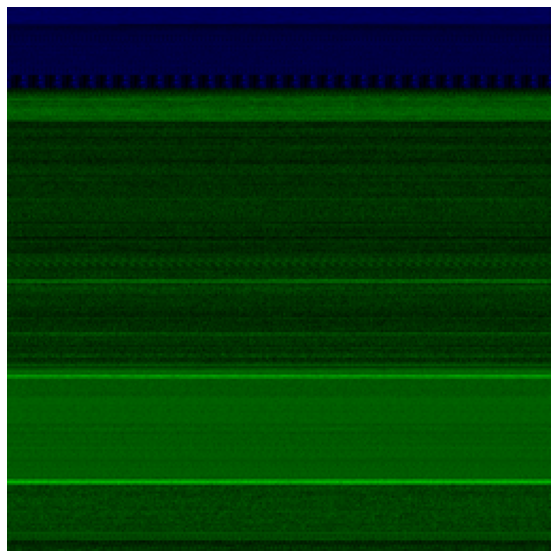

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
plt.axis('off')

# show the image
plt.imshow(mpimg.imread(files[0]))

Each image is a visual representation of an executable's bytecode, where each pixel is in the range of [0, 255]. Each pixel is colored corresponding to the section that the bytecode originates from (e.g., header, data).

## Part 2. Dimensionality reduction using PCA

One of the most popular forms of dimensionality reduction is Principal Components Analysis (PCA). Given a set of data, PCA finds a low dimensional representation of the data while preserving as much of the data's variation as possible. By using PCA to find a low dimensional reprsentation of the data, we can perform a variety of important downstream e.g., data visualization, clustering.

Lets begin by running PCA using [cuML](https://github.com/rapidsai/cuml), a [GPU accelerated version of PCA](https://docs.rapids.ai/api/cuml/stable/api.html), and plotting the amount of information (data variance) retained in the first 30 principal components.

In [ ]:
from numpy import cumsum
import matplotlib.pyplot as plt
import cuml

# find the 30 most important image features (i.e., principal components)
# pca = ...
pca.fit(images)

# transform the images represented as 1D numpy arrays into a low dimensional space
# embedding = ...

# calculate the amount of information "lost" due to the low dimensional image representation
# explained_variance = ...

# plot the amount of "information kept" vs the number of principal components (image features)
plt.plot(list(range(len(explained_variance))), explained_variance)

# Plot '# of principal components (features)' vs 'Variance Explained (%)'
# ... implement your code here

In the figure above, we see that 95% of the image information can be represented using just the first 30 principal components. This allows us to reduce our original data matrix to less than 1% of its original size while keeping nearly all of the information!

## Part 3. Visualizing low dimensional image embedddings

Now lets visualize these malware images in 2D. While the first 2 principal components only contain ~50% of the image information, its enough to create some interesting visualizations. 
In fact, looking at the figure below we see that the 3 malware types form distinct clusters. 


In [ ]:
class_colors = {21: "#1f77b4", 25: "#ff7f0e", 26: "#2ca02c"}  # assign colors to each class
label_colors = np.asarray([class_colors[l] for l in labels])  # assign colors to each label

# create a scatter plot of the first 2 principal components

# ... implement your code here

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('2-D Malware Image Embeddings')
plt.legend()

If we were to classify these 3 types of malware using dimensionality reduction, would we want to use 2 components, or more? Explain why.